# Example Predictor: Linear Rollout Predictor

This example contains basic functionality for training and evaluating a linear predictor that rolls out predictions day-by-day.

First, a training data set is created from historical case and npi data.

Second, a linear model is trained to predict future cases from prior case data along with prior and future npi data.
The model is an off-the-shelf sklearn Lasso model, that uses a positive weight constraint to enforce the assumption that increased npis has a negative correlation with future cases.

Third, a sample evaluation set is created, and the predictor is applied to this evaluation set to produce prediction results in the correct format.

## Training

In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

In [2]:
# Helpful function to compute mae
def mae(pred, true):
    return np.mean(np.abs(pred - true))

### Copy the data locally

In [3]:
# Main source for the training data
DATA_URL = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
# Local file
DATA_FILE = 'data/OxCGRT_latest.csv'

In [4]:
import os
import urllib.request
if not os.path.exists('data'):
    os.mkdir('data')
urllib.request.urlretrieve(DATA_URL, DATA_FILE)

('data/OxCGRT_latest.csv', <http.client.HTTPMessage at 0x7fc77a9ef190>)

In [5]:
# Load historical data from local file
df = pd.read_csv(DATA_FILE, 
                 parse_dates=['Date'],
                 encoding="ISO-8859-1",
                 dtype={"RegionName": str,
                        "RegionCode": str},
                 error_bad_lines=False)

In [6]:
df.columns

Index(['CountryName', 'CountryCode', 'RegionName', 'RegionCode',
       'Jurisdiction', 'Date', 'C1_School closing', 'C1_Flag',
       'C2_Workplace closing', 'C2_Flag', 'C3_Cancel public events', 'C3_Flag',
       'C4_Restrictions on gatherings', 'C4_Flag', 'C5_Close public transport',
       'C5_Flag', 'C6_Stay at home requirements', 'C6_Flag',
       'C7_Restrictions on internal movement', 'C7_Flag',
       'C8_International travel controls', 'E1_Income support', 'E1_Flag',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H1_Flag', 'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'H6_Facial Coverings', 'H6_Flag', 'H7_Vaccination policy', 'H7_Flag',
       'M1_Wildcard', 'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex',
       'StringencyIndexForDisplay', 'StringencyLegacyIndex',
       'StringencyLegacyIndexForDispla

In [7]:
# # For testing, restrict training data to that before a hypothetical predictor submission date
# HYPOTHETICAL_SUBMISSION_DATE = np.datetime64("2020-07-31")
# df = df[df.Date <= HYPOTHETICAL_SUBMISSION_DATE]

In [8]:
# Add RegionID column that combines CountryName and RegionName for easier manipulation of data
df['GeoID'] = df['CountryName'] + '__' + df['RegionName'].astype(str)

In [9]:
# Add new cases column
df['NewCases'] = df.groupby('GeoID').ConfirmedCases.diff().fillna(0)

In [10]:
# Keep only columns of interest
id_cols = ['CountryName',
           'RegionName',
           'GeoID',
           'Date']
cases_col = ['NewCases']
npi_cols = ['C1_School closing',
            'C2_Workplace closing',
            'C3_Cancel public events',
            'C4_Restrictions on gatherings',
            'C5_Close public transport',
            'C6_Stay at home requirements',
            'C7_Restrictions on internal movement',
            'C8_International travel controls',
            'H1_Public information campaigns',
            'H2_Testing policy',
            'H3_Contact tracing',
            'H6_Facial Coverings']
df = df[id_cols + cases_col + npi_cols]

In [11]:
# Fill any missing case values by interpolation and setting NaNs to 0
df.update(df.groupby('GeoID').NewCases.apply(
    lambda group: group.interpolate()).fillna(0))

In [12]:
# Fill any missing NPIs by assuming they are the same as previous day
for npi_col in npi_cols:
    df.update(df.groupby('GeoID')[npi_col].ffill().fillna(0))

In [13]:
temp = pd.read_csv('temperature_data.csv')
temp['date_st'] = temp['Date'].apply(lambda e: e[5:])
temp['id'] = temp['GeoID'] + '_' + temp['date_st']
id_temp = dict(zip( temp['id'], temp['temp'] ))
id_holiday = dict(zip( temp['id'], temp['Holiday'] ))
tf = temp[['date_st','temp']]
tf = tf.groupby(['date_st']).mean().reset_index()
date_temp_avg = dict(zip( tf['date_st'], tf['temp'] ))
tf = temp[['date_st','Holiday']]
tf = tf.groupby(['date_st'])['Holiday'].agg(pd.Series.mode).reset_index()
date_holiday_avg = dict(zip( tf['date_st'], tf['Holiday'] ))
id_temp

{'Afghanistan__nan_01-01': 2.7268292682926836,
 'Afghanistan__nan_01-02': 2.9152032520325206,
 'Afghanistan__nan_01-03': 2.9459349593495934,
 'Afghanistan__nan_01-04': 2.7965853658536584,
 'Afghanistan__nan_01-05': 2.4123577235772347,
 'Afghanistan__nan_01-06': 2.3713008130081303,
 'Afghanistan__nan_01-07': 2.4534959349593493,
 'Afghanistan__nan_01-08': 2.2549593495934954,
 'Afghanistan__nan_01-09': 2.219268292682927,
 'Afghanistan__nan_01-10': 2.2303252032520327,
 'Afghanistan__nan_01-11': 2.563983739837398,
 'Afghanistan__nan_01-12': 2.7221951219512204,
 'Afghanistan__nan_01-13': 2.389186991869919,
 'Afghanistan__nan_01-14': 2.290813008130081,
 'Afghanistan__nan_01-15': 2.217967479674797,
 'Afghanistan__nan_01-16': 2.2412195121951224,
 'Afghanistan__nan_01-17': 2.432926829268292,
 'Afghanistan__nan_01-18': 2.406747967479675,
 'Afghanistan__nan_01-19': 2.1417886178861787,
 'Afghanistan__nan_01-20': 2.324878048780488,
 'Afghanistan__nan_01-21': 2.0624390243902444,
 'Afghanistan__nan_01

In [14]:
# Set number of past days to use to make predictions
nb_lookback_days = 30
date_ls = []
geoid_ls = []
country_ls = []
newcase_ls = []
# Create training data across all countries for predicting one day ahead
X_cols = cases_col + npi_cols
y_col = cases_col
X_samples = []
y_samples = []
geo_ids = df.GeoID.unique()
train_geo_ids = [e for e in geo_ids]
geoid_arr = np.zeros(len(train_geo_ids)+1)
for g in geo_ids:
    gdf = df[df.GeoID == g]
    all_case_data = np.array(gdf[cases_col])
    all_npi_data = np.array(gdf[npi_cols])

    # Create one sample for each day where we have enough data
    # Each sample consists of cases and npis for previous nb_lookback_days
    nb_total_days = len(gdf)
    for d in range(nb_lookback_days, nb_total_days - 1):
        X_cases = all_case_data[d-nb_lookback_days:d]

        # Take negative of npis to support positive
        # weight constraint in Lasso.
        X_npis = -all_npi_data[d - nb_lookback_days:d]
        
        date_ls += [ list(gdf['Date'])[d] ]
        geoid_ls += [ list(gdf['GeoID'])[d] ]
        country_ls += [ list(gdf['CountryName'])[d]  ] 
        newcase_ls += [ list(gdf['NewCases'])[d]  ] 
        
        date_st = str(date_ls[-1])[5:10] 
        id_ = geoid_ls[-1] + '_' + date_st

        temperature = date_temp_avg[date_st]
        holiday = date_holiday_avg[date_st]
        if id_ in id_temp:
            temperature = id_temp[id_]
            holiday = id_holiday[id_]            
        
        # Flatten all input data so it fits Lasso input format.
        geoid_arr = np.zeros(len(train_geo_ids)+1)
        geoid_arr[ train_geo_ids.index(g) ] = 1
        X_sample = np.concatenate([geoid_arr, [temperature,holiday], X_cases.flatten(),
                                   X_npis.flatten()])
        y_sample = all_case_data[d]
        X_samples.append(X_sample)
        y_samples.append(y_sample)


X_samples = np.array(X_samples)
y_samples = np.array(y_samples).flatten()
with open('train_geo_ids.txt', 'w') as f:
    f.write('\n'.join(train_geo_ids))
    
print(X_samples.shape)

(89600, 673)


In [15]:
X_train, y_train = X_samples,y_samples
print(X_train.shape,y_train.shape)

(89600, 673) (89600,)


In [16]:
# import datetime
# train_idx = [i for i in range(len(date_ls)) if date_ls[i] <= datetime.date(2020,7,31) ]
# test_idx = [i for i in range(len(date_ls)) if date_ls[i] >= datetime.date(2020,8,1) ]
# train_idx = np.array(train_idx)
# test_idx = np.array(test_idx)

In [17]:
# # Split data into train and test sets
# X_train, X_test, y_train, y_test = X_samples[train_idx,:], X_samples[test_idx,:],y_samples[train_idx], y_samples[test_idx]
# print(X_train.shape,X_test.shape,y_train.shape,y_test.shape,)

In [18]:
!pip install lightgbm

In [19]:
import random
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
seed_everything(42) 

In [20]:
# Create and train Lasso model.
# Set positive=True to enforce assumption that cases are positively correlated
# with future cases and npis are negatively correlated.

lasso_model = Lasso(random_state=42)
lasso_model.fit(X_train, y_train)

print('Lasso result:')
# Evaluate model
train_preds = lasso_model.predict(X_train)
train_preds = np.maximum(train_preds, 0) # Don't predict negative cases
print('Train MAE:', mae(train_preds, y_train))
# test_preds = lasso_model.predict(X_test)
# test_preds = np.maximum(test_preds, 0) # Don't predict negative cases
# print('Test MAE:', mae(test_preds, y_test))
with open('models/model_lasso.pkl', 'wb') as model_file:
    pickle.dump(lasso_model, model_file)

from lightgbm import LGBMRegressor
lgbm_model = LGBMRegressor(random_state=42)
lgbm_model.fit(X_train, y_train)
# Evaluate model
train_preds = lgbm_model.predict(X_train)
train_preds = np.maximum(train_preds, 0) # Don't predict negative cases
print('lgbm result:')
print('Train MAE:', mae(train_preds, y_train))
# test_preds = lgbm_model.predict(X_test)
# test_preds = np.maximum(test_preds, 0) # Don't predict negative cases
# print('Test MAE:', mae(test_preds, y_test))
with open('models/model_lgbm.pkl', 'wb') as model_file:
    pickle.dump(lgbm_model, model_file)

import xgboost as xgb
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
# Evaluate model
train_preds = xgb_model.predict(X_train)
train_preds = np.maximum(train_preds, 0) # Don't predict negative cases
print('xgb result:')
print('Train MAE:', mae(train_preds, y_train))
# test_preds = xgb_model.predict(X_test)
# test_preds = np.maximum(test_preds, 0) # Don't predict negative cases
# print('Test MAE:', mae(test_preds, y_test))
with open('models/model_xgb.pkl', 'wb') as model_file:
    pickle.dump(xgb_model, model_file)


Lasso result:
Train MAE: 290.1623673351178
lgbm result:
Train MAE: 202.796486246035
xgb result:
Train MAE: 123.55096728445862


In [21]:
#with geoid
# Lasso result:
# Train MAE: 118.69420734991954
# Test MAE: 447.06846062728135
# lgbm result:
# Train MAE: 85.51717187475573
# Test MAE: 650.7371662424473
# xgb result:
# Train MAE: 54.2057830354577
# Test MAE: 633.3338386238983

In [22]:
# None geoid result:
# Lasso result:
# Train MAE: 119.2762230373797
# Test MAE: 469.3599710917388
# lgbm result:
# Train MAE: 85.58646245869078
# Test MAE: 665.2549123382636
# xgb result:
# Train MAE: 51.797418546131624
# Test MAE: 650.3725903829637

In [23]:
# Save the best model to file
if not os.path.exists('models'):
    os.mkdir('models')
with open('models/model.pkl', 'wb') as model_file:
    pickle.dump(lasso_model, model_file)

## Evaluation

Now that the predictor has been trained and saved, this section contains the functionality for evaluating it on sample evaluation data.

In [24]:
# Reload the module to get the latest changes
import predict
from importlib import reload
reload(predict)
from predict import predict_df

In [25]:
%%time
preds_df = predict_df("2020-08-01", "2020-08-31", path_to_ips_file="data/2020-09-30_historical_ip.csv", verbose=True)


Predicting for Aruba__nan
2020-08-01: 0
2020-08-02: 9.618598172040677
2020-08-03: 69.02905637802075
2020-08-04: 0
2020-08-05: 0
2020-08-06: 0
2020-08-07: 0
2020-08-08: 0
2020-08-09: 0
2020-08-10: 0
2020-08-11: 0
2020-08-12: 0
2020-08-13: 0
2020-08-14: 0
2020-08-15: 0
2020-08-16: 0
2020-08-17: 0
2020-08-18: 0
2020-08-19: 0
2020-08-20: 0
2020-08-21: 843.3589415843252
2020-08-22: 0
2020-08-23: 0
2020-08-24: 0
2020-08-25: 0
2020-08-26: 0
2020-08-27: 33.287260439527074
2020-08-28: 193.02485237044124
2020-08-29: 0
2020-08-30: 0
2020-08-31: 23.61109888256567

Predicting for Afghanistan__nan
2020-08-01: 49.37547303124629
2020-08-02: 0
2020-08-03: 111.46663058883867
2020-08-04: 531.4460066118604
2020-08-05: 133.4720700919318
2020-08-06: 93.25323505858256
2020-08-07: 0
2020-08-08: 0
2020-08-09: 0
2020-08-10: 14.990370528826446
2020-08-11: 172.57442840995807
2020-08-12: 27.961605604207392
2020-08-13: 0
2020-08-14: 0
2020-08-15: 0
2020-08-16: 0
2020-08-17: 0
2020-08-18: 90.10929833060591
2020-08-

2020-08-13: 58.9071017618365
2020-08-14: 68.7996542935568
2020-08-15: 56.32339124767955
2020-08-16: 93.03627541746462
2020-08-17: 121.38078624548444
2020-08-18: 64.43792248226136
2020-08-19: 0
2020-08-20: 44.386058040964315
2020-08-21: 347.8633913365186
2020-08-22: 0
2020-08-23: 0
2020-08-24: 0
2020-08-25: 0
2020-08-26: 0
2020-08-27: 0
2020-08-28: 7.448247214668484
2020-08-29: 0
2020-08-30: 0
2020-08-31: 1.8808493594323181

Predicting for Belgium__nan
2020-08-01: 2031.6825638238683
2020-08-02: 1649.6330796600087
2020-08-03: 2948.8431495539435
2020-08-04: 2609.5886185019317
2020-08-05: 1241.8163585070592
2020-08-06: 1322.2672089160844
2020-08-07: 1706.0777323697416
2020-08-08: 1751.36214459712
2020-08-09: 1485.9003196764734
2020-08-10: 2939.864269532991
2020-08-11: 2797.4417145556827
2020-08-12: 1106.947063321329
2020-08-13: 969.4654815958127
2020-08-14: 947.5008911916765
2020-08-15: 1759.7361282274949
2020-08-16: 1795.5708980543966
2020-08-17: 2744.1760156882647
2020-08-18: 2622.868516

2020-08-17: 338.97539502885024
2020-08-18: 306.2111354269477
2020-08-19: 164.74158153301966
2020-08-20: 133.19886492333475
2020-08-21: 0
2020-08-22: 194.55749885644428
2020-08-23: 249.97384864426277
2020-08-24: 274.7050222819858
2020-08-25: 268.5743143264976
2020-08-26: 180.38146138588374
2020-08-27: 89.08328561098443
2020-08-28: 51.52862055762631
2020-08-29: 149.2870126357381
2020-08-30: 183.1486070987986
2020-08-31: 178.06698975290908

Predicting for Brazil__Acre
2020-08-01: 88.16937101574509
2020-08-02: 21.05619426145489
2020-08-03: 0
2020-08-04: 369.19327082287464
2020-08-05: 50.89191469829274
2020-08-06: 72.26964912693704
2020-08-07: 81.02183134855218
2020-08-08: 0
2020-08-09: 0
2020-08-10: 0
2020-08-11: 0
2020-08-12: 0
2020-08-13: 0
2020-08-14: 0
2020-08-15: 0
2020-08-16: 0
2020-08-17: 0
2020-08-18: 0
2020-08-19: 0
2020-08-20: 0
2020-08-21: 0
2020-08-22: 0
2020-08-23: 0
2020-08-24: 0
2020-08-25: 0
2020-08-26: 0
2020-08-27: 0
2020-08-28: 0
2020-08-29: 0
2020-08-30: 0
2020-08-31: 0

2020-08-26: 420.6511792884387
2020-08-27: 619.2236227382193
2020-08-28: 643.8301592593634
2020-08-29: 342.3170436742695
2020-08-30: 0
2020-08-31: 0

Predicting for Brazil__Para
2020-08-01: 917.7172766150475
2020-08-02: 434.140064567895
2020-08-03: 334.0588065283923
2020-08-04: 92.95386253395881
2020-08-05: 396.66479913571425
2020-08-06: 575.3670196300012
2020-08-07: 979.0777669931269
2020-08-08: 831.6235033310194
2020-08-09: 365.6461979798893
2020-08-10: 218.16145967982365
2020-08-11: 184.65262635574905
2020-08-12: 427.52682936614445
2020-08-13: 1165.3978911563333
2020-08-14: 918.548882416807
2020-08-15: 732.7832472737825
2020-08-16: 195.153733376753
2020-08-17: 47.31463173779291
2020-08-18: 40.541927527766795
2020-08-19: 261.9645158716537
2020-08-20: 831.3985696892424
2020-08-21: 1246.4983284793489
2020-08-22: 674.0577764129437
2020-08-23: 149.49777271912438
2020-08-24: 0
2020-08-25: 0
2020-08-26: 139.08740363590633
2020-08-27: 702.1755471127847
2020-08-28: 765.7107492870241
2020-08-2

2020-08-04: 0
2020-08-05: 0
2020-08-06: 1791.3301480198363
2020-08-07: 4954.806483229687
2020-08-08: 4658.219114202089
2020-08-09: 741.6120420315428
2020-08-10: 0
2020-08-11: 0
2020-08-12: 0
2020-08-13: 1742.0101875201246
2020-08-14: 2813.158234612054
2020-08-15: 4448.440637638272
2020-08-16: 860.719874407672
2020-08-17: 0
2020-08-18: 0
2020-08-19: 0
2020-08-20: 1154.6750538459912
2020-08-21: 2814.165693630963
2020-08-22: 4133.386731385684
2020-08-23: 1248.5434544155853
2020-08-24: 0
2020-08-25: 0
2020-08-26: 0
2020-08-27: 1258.6244792847676
2020-08-28: 2612.6421037544105
2020-08-29: 3880.253113953552
2020-08-30: 869.5834117259618
2020-08-31: 0

Predicting for Brazil__Tocantins
2020-08-01: 275.88831729933116
2020-08-02: 93.03230476879193
2020-08-03: 59.245209594715035
2020-08-04: 363.28697099360346
2020-08-05: 45.484196210028074
2020-08-06: 229.12408738818397
2020-08-07: 309.4769841910404
2020-08-08: 171.99535197649317
2020-08-09: 0
2020-08-10: 33.28975192470935
2020-08-11: 61.04061475

2020-08-11: 63.72220848863532
2020-08-12: 0
2020-08-13: 0
2020-08-14: 0
2020-08-15: 0
2020-08-16: 0
2020-08-17: 10.26786668883284
2020-08-18: 12.695491865180081
2020-08-19: 0
2020-08-20: 0
2020-08-21: 0
2020-08-22: 0
2020-08-23: 0
2020-08-24: 0
2020-08-25: 0
2020-08-26: 0
2020-08-27: 0
2020-08-28: 0
2020-08-29: 0
2020-08-30: 0
2020-08-31: 0

Predicting for Cameroon__nan
2020-08-01: 24.173457855445974
2020-08-02: 100.51347545002005
2020-08-03: 72.35281259136401
2020-08-04: 200.09553984582206
2020-08-05: 96.50405389275903
2020-08-06: 50.05667970771236
2020-08-07: 52.63267410225845
2020-08-08: 4.215048008929955
2020-08-09: 53.486438578996754
2020-08-10: 42.552633743291196
2020-08-11: 0
2020-08-12: 9.321055837578655
2020-08-13: 0
2020-08-14: 0
2020-08-15: 0
2020-08-16: 0
2020-08-17: 0
2020-08-18: 0
2020-08-19: 0
2020-08-20: 0
2020-08-21: 0
2020-08-22: 0
2020-08-23: 0
2020-08-24: 0
2020-08-25: 0
2020-08-26: 0
2020-08-27: 0
2020-08-28: 0
2020-08-29: 0
2020-08-30: 0
2020-08-31: 0

Predicting 

2020-08-03: 24128.674447921527
2020-08-04: 10286.107384933499
2020-08-05: 14080.896008272444
2020-08-06: 22614.84415244339
2020-08-07: 21020.123406063827
2020-08-08: 28480.769107918866
2020-08-09: 25319.335694397905
2020-08-10: 19488.55878315074
2020-08-11: 9193.816631593425
2020-08-12: 9877.001820844884
2020-08-13: 21763.873541728375
2020-08-14: 18119.279912695893
2020-08-15: 29362.035027213416
2020-08-16: 26625.99852303425
2020-08-17: 21378.550481800543
2020-08-18: 10072.043298684632
2020-08-19: 10126.189137138012
2020-08-20: 19390.254661834435
2020-08-21: 19383.0148859411
2020-08-22: 25650.618844490156
2020-08-23: 26867.537377386026
2020-08-24: 17493.38218827057
2020-08-25: 10722.266714737823
2020-08-26: 10232.848669003959
2020-08-27: 20702.249622350748
2020-08-28: 19002.06350610985
2020-08-29: 27926.924020931347
2020-08-30: 24376.46675024116
2020-08-31: 17777.003232969666

Predicting for Djibouti__nan
2020-08-01: 0
2020-08-02: 0
2020-08-03: 0
2020-08-04: 185.13455173674498
2020-08-

2020-08-01: 456.3609838798004
2020-08-02: 471.26053199010437
2020-08-03: 544.1313982961813
2020-08-04: 822.6096435144204
2020-08-05: 389.62627136145824
2020-08-06: 237.3599435390662
2020-08-07: 183.9047624669372
2020-08-08: 271.0974489299076
2020-08-09: 318.8311823677907
2020-08-10: 434.75481935219534
2020-08-11: 464.05900271221617
2020-08-12: 284.49482070516166
2020-08-13: 126.95130766489302
2020-08-14: 74.42884890728988
2020-08-15: 237.9716182667447
2020-08-16: 271.8613443219416
2020-08-17: 400.5694396284259
2020-08-18: 378.51470824938724
2020-08-19: 56.32515842110581
2020-08-20: 0
2020-08-21: 0
2020-08-22: 65.15177437902722
2020-08-23: 172.85481314899235
2020-08-24: 272.24137973923723
2020-08-25: 282.4816050544513
2020-08-26: 67.05066999179081
2020-08-27: 0
2020-08-28: 0
2020-08-29: 0
2020-08-30: 45.3327323987842
2020-08-31: 110.52351664479676

Predicting for Finland__nan
2020-08-01: 524.3980636938834
2020-08-02: 492.0001777572977
2020-08-03: 535.3577057347403
2020-08-04: 464.287738

2020-08-18: 93.45886319418872
2020-08-19: 0
2020-08-20: 0
2020-08-21: 0
2020-08-22: 0
2020-08-23: 0
2020-08-24: 0
2020-08-25: 0
2020-08-26: 0
2020-08-27: 0
2020-08-28: 0
2020-08-29: 0
2020-08-30: 0
2020-08-31: 0

Predicting for Guinea__nan
2020-08-01: 0
2020-08-02: 0
2020-08-03: 0.99180803287733
2020-08-04: 154.50994963186548
2020-08-05: 0
2020-08-06: 159.55800265185445
2020-08-07: 0
2020-08-08: 0
2020-08-09: 0
2020-08-10: 0
2020-08-11: 0
2020-08-12: 0
2020-08-13: 0
2020-08-14: 0
2020-08-15: 0
2020-08-16: 0
2020-08-17: 0
2020-08-18: 0
2020-08-19: 0
2020-08-20: 0
2020-08-21: 0
2020-08-22: 0
2020-08-23: 0
2020-08-24: 0
2020-08-25: 0
2020-08-26: 0
2020-08-27: 0
2020-08-28: 0
2020-08-29: 0
2020-08-30: 0
2020-08-31: 0

Predicting for Gambia__nan
2020-08-01: 0
2020-08-02: 0
2020-08-03: 11.058024605100869
2020-08-04: 7.755999475386872
2020-08-05: 0
2020-08-06: 0
2020-08-07: 0
2020-08-08: 0
2020-08-09: 234.6539487974635
2020-08-10: 0
2020-08-11: 0
2020-08-12: 0
2020-08-13: 0
2020-08-14: 0
2020

2020-08-31: 3010.080245326103

Predicting for Indonesia__nan
2020-08-01: 6725.622891047714
2020-08-02: 6014.559277410077
2020-08-03: 6138.082251985883
2020-08-04: 5847.217635204757
2020-08-05: 5492.285513331434
2020-08-06: 4080.440877190611
2020-08-07: 3730.785857779255
2020-08-08: 5405.780432139039
2020-08-09: 5800.919272321591
2020-08-10: 5389.650145798391
2020-08-11: 5368.167164208239
2020-08-12: 4530.259042638583
2020-08-13: 3572.9743883649053
2020-08-14: 2593.003330692879
2020-08-15: 5535.533256524254
2020-08-16: 5528.358656738641
2020-08-17: 5790.954771998892
2020-08-18: 4964.078023300475
2020-08-19: 4173.937973587984
2020-08-20: 3100.8949517546725
2020-08-21: 2689.813312950042
2020-08-22: 4401.1406642041375
2020-08-23: 5452.1003887143725
2020-08-24: 4859.963523134953
2020-08-25: 4922.854728343254
2020-08-26: 3865.02987578574
2020-08-27: 3072.8857080248044
2020-08-28: 2283.4282336729366
2020-08-29: 4515.36442181534
2020-08-30: 4799.56097904646
2020-08-31: 4902.270212559567

Predi

2020-08-06: 36.89510524092293
2020-08-07: 90.84795142953331
2020-08-08: 270.8497379187097
2020-08-09: 335.79464581565617
2020-08-10: 230.82936429138243
2020-08-11: 57.095339543490496
2020-08-12: 0
2020-08-13: 0
2020-08-14: 0
2020-08-15: 140.92098097846997
2020-08-16: 164.93966559492432
2020-08-17: 121.11733448906666
2020-08-18: 0
2020-08-19: 0
2020-08-20: 0
2020-08-21: 0
2020-08-22: 37.994851022315956
2020-08-23: 134.52955609370326
2020-08-24: 29.324946117022563
2020-08-25: 0
2020-08-26: 0
2020-08-27: 0
2020-08-28: 0
2020-08-29: 8.079848897706356
2020-08-30: 61.428531404970016
2020-08-31: 0

Predicting for Kyrgyz Republic__nan
2020-08-01: 383.9100427585704
2020-08-02: 276.3350354150465
2020-08-03: 204.33334163723342
2020-08-04: 653.8590101853457
2020-08-05: 139.61114740460778
2020-08-06: 152.44902949254345
2020-08-07: 137.30672964725701
2020-08-08: 259.6247068922388
2020-08-09: 189.5079702224712
2020-08-10: 116.26459728284556
2020-08-11: 300.2463030902467
2020-08-12: 142.17896169182416

2020-08-20: 0
2020-08-21: 322.8854234374476
2020-08-22: 378.26580776706743
2020-08-23: 68.42745287098771
2020-08-24: 0
2020-08-25: 0
2020-08-26: 249.51984319460706
2020-08-27: 55.30573184192635
2020-08-28: 136.89841495178837
2020-08-29: 422.06552696986535
2020-08-30: 133.6094952171193
2020-08-31: 0

Predicting for Latvia__nan
2020-08-01: 825.502344314594
2020-08-02: 729.0762152813791
2020-08-03: 767.350231124126
2020-08-04: 900.3425908638148
2020-08-05: 297.4288396413857
2020-08-06: 410.2940696728707
2020-08-07: 471.2646629241283
2020-08-08: 756.2876557965827
2020-08-09: 707.8389480493162
2020-08-10: 763.0056654708485
2020-08-11: 570.0828000130821
2020-08-12: 236.11022404735272
2020-08-13: 343.68133152930716
2020-08-14: 379.1627595513964
2020-08-15: 764.0238167084512
2020-08-16: 753.8078378622226
2020-08-17: 800.9889965418349
2020-08-18: 579.3415247393297
2020-08-19: 126.67293150899562
2020-08-20: 192.4115054653442
2020-08-21: 100.20293725606271
2020-08-22: 607.025880464356
2020-08-23:

2020-08-01: 0
2020-08-02: 50.32061847422838
2020-08-03: 113.34917174720454
2020-08-04: 0
2020-08-05: 87.47296794231731
2020-08-06: 16.21188374918924
2020-08-07: 68.81050925993111
2020-08-08: 59.77489442513912
2020-08-09: 92.82228265336299
2020-08-10: 110.61789005466784
2020-08-11: 24.36978038697451
2020-08-12: 36.8961990354293
2020-08-13: 25.33984773856259
2020-08-14: 36.7082145483806
2020-08-15: 22.413807542771217
2020-08-16: 62.96081620104716
2020-08-17: 88.85267352242415
2020-08-18: 28.85842022701193
2020-08-19: 0
2020-08-20: 0
2020-08-21: 305.4882963694582
2020-08-22: 0
2020-08-23: 0
2020-08-24: 0
2020-08-25: 0
2020-08-26: 0
2020-08-27: 0
2020-08-28: 0
2020-08-29: 0
2020-08-30: 0
2020-08-31: 0

Predicting for Malawi__nan
2020-08-01: 0
2020-08-02: 0
2020-08-03: 34.385457827139476
2020-08-04: 407.6833622283382
2020-08-05: 34.02303541235514
2020-08-06: 0
2020-08-07: 2.389086352542776
2020-08-08: 0
2020-08-09: 0
2020-08-10: 82.55704858059698
2020-08-11: 114.70250741885201
2020-08-12: 2

2020-08-07: 1443.5981923066252
2020-08-08: 2077.735851596748
2020-08-09: 2207.9912586240953
2020-08-10: 2322.6504103248617
2020-08-11: 2017.0313125312875
2020-08-12: 1732.6396093808564
2020-08-13: 1255.900234894691
2020-08-14: 939.4306996558851
2020-08-15: 1859.7064434544334
2020-08-16: 1990.1625623175794
2020-08-17: 2140.0223793652185
2020-08-18: 1738.3138253292493
2020-08-19: 1133.811311487813
2020-08-20: 828.2668440276653
2020-08-21: 331.80801254111316
2020-08-22: 1295.8293827179773
2020-08-23: 1770.5849076740687
2020-08-24: 1688.0799842310705
2020-08-25: 1515.468644525973
2020-08-26: 1006.408045484618
2020-08-27: 530.3808476091946
2020-08-28: 110.02941353115898
2020-08-29: 991.5954193068578
2020-08-30: 1231.5750351623485
2020-08-31: 1294.04800133456

Predicting for Panama__nan
2020-08-01: 2460.034601364896
2020-08-02: 2601.391838172931
2020-08-03: 2636.9804472077185
2020-08-04: 2500.9133713727006
2020-08-05: 1795.6790477814045
2020-08-06: 1649.4021288021956
2020-08-07: 1451.3747666

2020-08-02: 7297.8161654986625
2020-08-03: 6748.505648614615
2020-08-04: 4054.3793746549563
2020-08-05: 2989.165801019166
2020-08-06: 3534.6814432534857
2020-08-07: 3199.3919485598763
2020-08-08: 5351.481047666159
2020-08-09: 5931.519941730653
2020-08-10: 5348.451026153141
2020-08-11: 3313.3356009912986
2020-08-12: 2430.414751613461
2020-08-13: 2963.5307791925516
2020-08-14: 2320.8507425745847
2020-08-15: 5257.332276556446
2020-08-16: 5736.51350538616
2020-08-17: 5075.070495726131
2020-08-18: 2473.683110138524
2020-08-19: 1213.1034852773055
2020-08-20: 1954.2307433058365
2020-08-21: 2052.7769486205543
2020-08-22: 4342.278918700954
2020-08-23: 5581.017713873913
2020-08-24: 4137.375833603868
2020-08-25: 2312.9522140215477
2020-08-26: 999.5501980553681
2020-08-27: 1565.929308768313
2020-08-28: 1365.0978089450887
2020-08-29: 4029.3536026064703
2020-08-30: 4589.970779100426
2020-08-31: 3839.2804156846933

Predicting for Russia__nan
2020-08-01: 26726.90827140431
2020-08-02: 27095.84447130423

2020-08-22: 3236.0600619276656
2020-08-23: 3805.6897265710368
2020-08-24: 2463.835427504254
2020-08-25: 2083.832133330725
2020-08-26: 1776.5201939922304
2020-08-27: 1739.6020156654788
2020-08-28: 1113.926424838879
2020-08-29: 2990.2441248561454
2020-08-30: 2797.788034794762
2020-08-31: 1998.8765238609674

Predicting for South Sudan__nan
2020-08-01: 0
2020-08-02: 0
2020-08-03: 19.619699854285187
2020-08-04: 365.7969206690078
2020-08-05: 0
2020-08-06: 0
2020-08-07: 0
2020-08-08: 0
2020-08-09: 0
2020-08-10: 20.0364374464926
2020-08-11: 39.222703756486226
2020-08-12: 0
2020-08-13: 0
2020-08-14: 0
2020-08-15: 0
2020-08-16: 0
2020-08-17: 0
2020-08-18: 31.143818491973562
2020-08-19: 0
2020-08-20: 0
2020-08-21: 0
2020-08-22: 0
2020-08-23: 0
2020-08-24: 0
2020-08-25: 0
2020-08-26: 0
2020-08-27: 0
2020-08-28: 0
2020-08-29: 0
2020-08-30: 0
2020-08-31: 0

Predicting for Suriname__nan
2020-08-01: 0
2020-08-02: 0
2020-08-03: 0
2020-08-04: 349.5858391392824
2020-08-05: 0
2020-08-06: 0
2020-08-07: 0
2

2020-08-21: 366.7074779051866
2020-08-22: 141.95612935046694
2020-08-23: 159.024392121858
2020-08-24: 200.6531413152317
2020-08-25: 132.49102150048662
2020-08-26: 87.51609524192318
2020-08-27: 113.12797632120605
2020-08-28: 125.33759146009346
2020-08-29: 53.17939814262748
2020-08-30: 54.46469438183249
2020-08-31: 151.0841505828669

Predicting for Timor-Leste__nan
2020-08-01: 0
2020-08-02: 42.82668479105169
2020-08-03: 104.93129106404746
2020-08-04: 294.4619494627217
2020-08-05: 97.0436604491072
2020-08-06: 26.02445431376384
2020-08-07: 64.1400364930654
2020-08-08: 57.9707643177058
2020-08-09: 84.01576449353891
2020-08-10: 165.40183798895313
2020-08-11: 136.32519832763703
2020-08-12: 81.8724125314405
2020-08-13: 51.58031658619847
2020-08-14: 61.41677172045638
2020-08-15: 47.555962600199756
2020-08-16: 85.37986610567565
2020-08-17: 152.8132375349352
2020-08-18: 155.84440498190122
2020-08-19: 0
2020-08-20: 0
2020-08-21: 0
2020-08-22: 0
2020-08-23: 0
2020-08-24: 0
2020-08-25: 0
2020-08-26:

2020-08-30: 1666.2564033547112
2020-08-31: 1497.2383359885569

Predicting for United States__Arizona
2020-08-01: 6182.0628386754015
2020-08-02: 7237.942648348555
2020-08-03: 7868.37904037378
2020-08-04: 7717.735293278536
2020-08-05: 7128.496227383089
2020-08-06: 7586.793451899472
2020-08-07: 4367.171516647177
2020-08-08: 5803.470425665045
2020-08-09: 7709.8212596024305
2020-08-10: 7663.519043091672
2020-08-11: 7388.0969301893465
2020-08-12: 6983.8115758382
2020-08-13: 5784.175620384508
2020-08-14: 3872.33968170101
2020-08-15: 5903.39221878786
2020-08-16: 8421.722079270985
2020-08-17: 8527.451860244311
2020-08-18: 7636.102814225592
2020-08-19: 6906.871207063883
2020-08-20: 6396.792166327978
2020-08-21: 3024.0307610365862
2020-08-22: 5960.434308096356
2020-08-23: 7209.665046944868
2020-08-24: 7825.076771948078
2020-08-25: 7486.005578713592
2020-08-26: 7510.423629583505
2020-08-27: 5751.996665357083
2020-08-28: 4010.7721168871803
2020-08-29: 5609.881598347593
2020-08-30: 7388.784436711242

2020-08-19: 0
2020-08-20: 0
2020-08-21: 0
2020-08-22: 0
2020-08-23: 0
2020-08-24: 83.29932311598664
2020-08-25: 122.75741443093419
2020-08-26: 49.7497054633282
2020-08-27: 0
2020-08-28: 0
2020-08-29: 0
2020-08-30: 0
2020-08-31: 23.07547255848843

Predicting for United States__Iowa
2020-08-01: 1480.5101289285906
2020-08-02: 1078.1359461391878
2020-08-03: 827.2986803942305
2020-08-04: 816.7524125335514
2020-08-05: 499.1023847793342
2020-08-06: 611.8909691256436
2020-08-07: 892.9070482172143
2020-08-08: 981.3213875482074
2020-08-09: 501.0584451844521
2020-08-10: 379.1470406523271
2020-08-11: 0
2020-08-12: 0
2020-08-13: 0
2020-08-14: 183.31234254325608
2020-08-15: 642.109527911159
2020-08-16: 398.3252556814901
2020-08-17: 135.88248329419042
2020-08-18: 0
2020-08-19: 0
2020-08-20: 0
2020-08-21: 0
2020-08-22: 177.82605672782918
2020-08-23: 0
2020-08-24: 0
2020-08-25: 0
2020-08-26: 0
2020-08-27: 0
2020-08-28: 0
2020-08-29: 127.1342416741316
2020-08-30: 0
2020-08-31: 0

Predicting for United S

2020-08-18: 2432.3094796003406
2020-08-19: 1584.4231481156455
2020-08-20: 1287.9523021936288
2020-08-21: 920.5675361144037
2020-08-22: 2134.1815227912266
2020-08-23: 2830.5452343397883
2020-08-24: 2706.5881970934724
2020-08-25: 2209.5833089480893
2020-08-26: 1559.0292579821737
2020-08-27: 1109.5281840057728
2020-08-28: 879.2282035954156
2020-08-29: 1988.4172804942602
2020-08-30: 2471.4896075108963
2020-08-31: 2483.174441502453

Predicting for United States__Maine
2020-08-01: 381.75723448253086
2020-08-02: 368.4513847787206
2020-08-03: 371.8317488508289
2020-08-04: 749.5699780019955
2020-08-05: 447.8633190607095
2020-08-06: 352.9170372119379
2020-08-07: 288.4694415149796
2020-08-08: 353.6805203784442
2020-08-09: 330.771987327412
2020-08-10: 397.41040456688995
2020-08-11: 400.38821204682114
2020-08-12: 376.8139608308364
2020-08-13: 264.6058249787434
2020-08-14: 169.5828394180236
2020-08-15: 309.1957486994104
2020-08-16: 290.1654693461993
2020-08-17: 385.0607731144168
2020-08-18: 402.0796

2020-08-18: 88.19924385831621
2020-08-19: 0
2020-08-20: 0
2020-08-21: 0
2020-08-22: 470.19179754323625
2020-08-23: 324.353028222274
2020-08-24: 0
2020-08-25: 0
2020-08-26: 0
2020-08-27: 0
2020-08-28: 0
2020-08-29: 285.6393329990988
2020-08-30: 11.486189802280222
2020-08-31: 0

Predicting for United States__New Hampshire
2020-08-01: 798.4788536663334
2020-08-02: 971.8391935519023
2020-08-03: 962.121701878142
2020-08-04: 1347.8327335007878
2020-08-05: 1106.9793648502202
2020-08-06: 827.1755219343717
2020-08-07: 655.105805120664
2020-08-08: 718.4757184487635
2020-08-09: 959.5376837494875
2020-08-10: 876.8470679098507
2020-08-11: 922.1827280356853
2020-08-12: 950.0229298515287
2020-08-13: 720.8037338992771
2020-08-14: 573.9587463317998
2020-08-15: 873.1111518262909
2020-08-16: 1022.4816306791124
2020-08-17: 1038.6644925328444
2020-08-18: 972.4037720525401
2020-08-19: 817.6245181040831
2020-08-20: 527.789253746781
2020-08-21: 188.1996825590391
2020-08-22: 580.3088680248158
2020-08-23: 871.9

2020-08-20: 6568.12464939305
2020-08-21: 6272.511815102687
2020-08-22: 11271.061213569135
2020-08-23: 13200.506307743184
2020-08-24: 10284.04635517079
2020-08-25: 9416.505494912777
2020-08-26: 8153.259220920753
2020-08-27: 6800.663418909057
2020-08-28: 6212.708451571631
2020-08-29: 11512.88622195886
2020-08-30: 12302.111311078592
2020-08-31: 10570.366375592803

Predicting for United States__Rhode Island
2020-08-01: 1252.1665644596571
2020-08-02: 1105.5475700546635
2020-08-03: 46.76096946204552
2020-08-04: 913.7945606074315
2020-08-05: 2752.4749435382246
2020-08-06: 1244.0853741922508
2020-08-07: 716.2162210165585
2020-08-08: 857.2294760889349
2020-08-09: 906.8099220054019
2020-08-10: 0
2020-08-11: 606.0071376190988
2020-08-12: 2383.521345769781
2020-08-13: 1142.8156255288166
2020-08-14: 499.5269173217057
2020-08-15: 953.4290792955127
2020-08-16: 684.9432992685865
2020-08-17: 107.0517333857675
2020-08-18: 578.4237645538492
2020-08-19: 2052.079861899206
2020-08-20: 967.3103994043547
2020

2020-08-19: 0
2020-08-20: 0
2020-08-21: 0
2020-08-22: 0
2020-08-23: 0
2020-08-24: 0
2020-08-25: 49.232054402420744
2020-08-26: 0
2020-08-27: 0
2020-08-28: 0
2020-08-29: 0
2020-08-30: 0
2020-08-31: 0

Predicting for United States__Washington
2020-08-01: 2569.519772921254
2020-08-02: 2907.7598364401174
2020-08-03: 2983.1576092684973
2020-08-04: 2538.2783856329715
2020-08-05: 3675.418433849204
2020-08-06: 1462.2187251087332
2020-08-07: 1436.5226103712303
2020-08-08: 1394.17914448488
2020-08-09: 2337.071846908955
2020-08-10: 2278.5567037321525
2020-08-11: 1763.8123251643235
2020-08-12: 2178.338117372008
2020-08-13: 1273.4122790817462
2020-08-14: 940.5650982118045
2020-08-15: 2204.0008281955525
2020-08-16: 2304.352205443006
2020-08-17: 2233.113594412209
2020-08-18: 1537.7846532409392
2020-08-19: 1765.6974671756745
2020-08-20: 562.4543962143956
2020-08-21: 310.9284771166798
2020-08-22: 1075.2682298053714
2020-08-23: 1927.4573936925774
2020-08-24: 1928.4364824644542
2020-08-25: 1751.297489962

CPU times: user 16.2 s, sys: 508 ms, total: 16.7 s
Wall time: 15 s


In [26]:
# Check the predictions
preds_df.head()

,CountryName,RegionName,Date,PredictedDailyNewCases
213,Aruba,NaN,2020-08-01,0.000000
214,Aruba,NaN,2020-08-02,9.618598
215,Aruba,NaN,2020-08-03,69.029056
216,Aruba,NaN,2020-08-04,0.000000
217,Aruba,NaN,2020-08-05,0.000000


# Validation
This is how the predictor is going to be called during the competition.  
!!! PLEASE DO NOT CHANGE THE API !!!

In [27]:
!python predict.py -s 2020-08-01 -e 2020-08-04 -ip data/2020-09-30_historical_ip.csv -o predictions/2020-08-01_2020-08-04.csv

Generating predictions from 2020-08-01 to 2020-08-04...
Saved predictions to predictions/2020-08-01_2020-08-04.csv
Done!


In [28]:
!head predictions/2020-08-01_2020-08-04.csv

CountryName,RegionName,Date,PredictedDailyNewCases
Aruba,,2020-08-01,0.0
Aruba,,2020-08-02,9.618598172040677
Aruba,,2020-08-03,69.02905637802075
Aruba,,2020-08-04,0.0
Afghanistan,,2020-08-01,49.37547303124629
Afghanistan,,2020-08-02,0.0
Afghanistan,,2020-08-03,111.46663058883867
Afghanistan,,2020-08-04,531.4460066118604
Angola,,2020-08-01,54.26171616787063


# Test cases
We can generate a prediction file. Let's validate a few cases...

In [29]:
import sys,os,os.path
sys.path.append(os.path.expanduser('/home/thinng/code/2020/covid-xprize/'))

In [30]:
import os
from covid_xprize.validation.predictor_validation import validate_submission

def validate(start_date, end_date, ip_file, output_file):
    # First, delete any potential old file
    try:
        os.remove(output_file)
    except OSError:
        pass
    
    # Then generate the prediction, calling the official API
    !python predict.py -s {start_date} -e {end_date} -ip {ip_file} -o {output_file}
    
    # And validate it
    errors = validate_submission(start_date, end_date, ip_file, output_file)
    if errors:
        for error in errors:
            print(error)
    else:
        print("All good!")

## 4 days, no gap
- All countries and regions
- Official number of cases is known up to start_date
- Intervention Plans are the official ones

In [31]:
validate(start_date="2020-08-01",
         end_date="2020-08-04",
         ip_file="data/2020-09-30_historical_ip.csv",
         output_file="predictions/val_4_days.csv")

Generating predictions from 2020-08-01 to 2020-08-04...
Saved predictions to predictions/val_4_days.csv
Done!
All good!


## 1 month in the future
- 2 countries only
- there's a gap between date of last known number of cases and start_date
- For future dates, Intervention Plans contains scenarios for which predictions are requested to answer the question: what will happen if we apply these plans?

In [32]:
%%time
validate(start_date="2021-01-01",
         end_date="2021-01-31",
         ip_file="data/future_ip.csv",
         output_file="predictions/val_1_month_future.csv")

Generating predictions from 2021-01-01 to 2021-01-31...
Saved predictions to predictions/val_1_month_future.csv
Done!
All good!
CPU times: user 276 ms, sys: 105 ms, total: 381 ms
Wall time: 7.85 s


## 180 days, from a future date, all countries and regions
- Prediction start date is 1 week from now. (i.e. assuming submission date is 1 week from now)  
- Prediction end date is 6 months after start date.  
- Prediction is requested for all available countries and regions.  
- Intervention plan scenario: freeze last known intervention plans for each country and region.  

As the number of cases is not known yet between today and start date, but the model relies on them, the model has to predict them in order to use them.  
This test is the most demanding test. It should take less than 1 hour to generate the prediction file.

### Generate the scenario

In [33]:
from datetime import datetime, timedelta

start_date = datetime.now() + timedelta(days=7)
start_date_str = start_date.strftime('%Y-%m-%d')
end_date = start_date + timedelta(days=180)
end_date_str = end_date.strftime('%Y-%m-%d')
print(f"Start date: {start_date_str}")
print(f"End date: {end_date_str}")

Start date: 2020-12-24
End date: 2021-06-22


In [34]:
from covid_xprize.validation.scenario_generator import get_raw_data, generate_scenario, NPI_COLUMNS
DATA_FILE = 'data/OxCGRT_latest.csv'
latest_df = get_raw_data(DATA_FILE, latest=True)
scenario_df = generate_scenario(start_date_str, end_date_str, latest_df, countries=None, scenario="Freeze")
scenario_file = "predictions/180_days_future_scenario.csv"
scenario_df.to_csv(scenario_file, index=False)
print(f"Saved scenario to {scenario_file}")

Saved scenario to predictions/180_days_future_scenario.csv


### Check it

In [35]:
%%time
validate(start_date=start_date_str,
         end_date=end_date_str,
         ip_file=scenario_file,
         output_file="predictions/val_6_month_future.csv")

Generating predictions from 2020-12-24 to 2021-06-22...
Saved predictions to predictions/val_6_month_future.csv
Done!
All good!
CPU times: user 6.61 s, sys: 1.18 s, total: 7.79 s
Wall time: 2min 39s


## predict zero scenario & plot "United States"/"Canada"/"Argentina" 

In [57]:
zero_scenario_df = pd.read_csv(scenario_file)
cols = list(zero_scenario_df.columns)[3:]
for col in cols:
    zero_scenario_df[col].values[:] = 0
zero_scenario_file = "predictions/180_days_future_scenario_zero.csv"
zero_scenario_df.to_csv(zero_scenario_file, index=False)
print(f"Saved scenario to {zero_scenario_file}")

Saved scenario to predictions/180_days_future_scenario_zero.csv


In [63]:
%%time
validate(start_date=start_date_str,
         end_date=end_date_str,
         ip_file=zero_scenario_file,
         output_file="predictions/val_6_month_future_zero.csv")

model_xgb
Generating predictions from 2020-12-24 to 2021-06-22...
Saved predictions to predictions/val_6_month_future_zero.csv
Done!
All good!
CPU times: user 6.56 s, sys: 1.2 s, total: 7.76 s
Wall time: 3min 36s


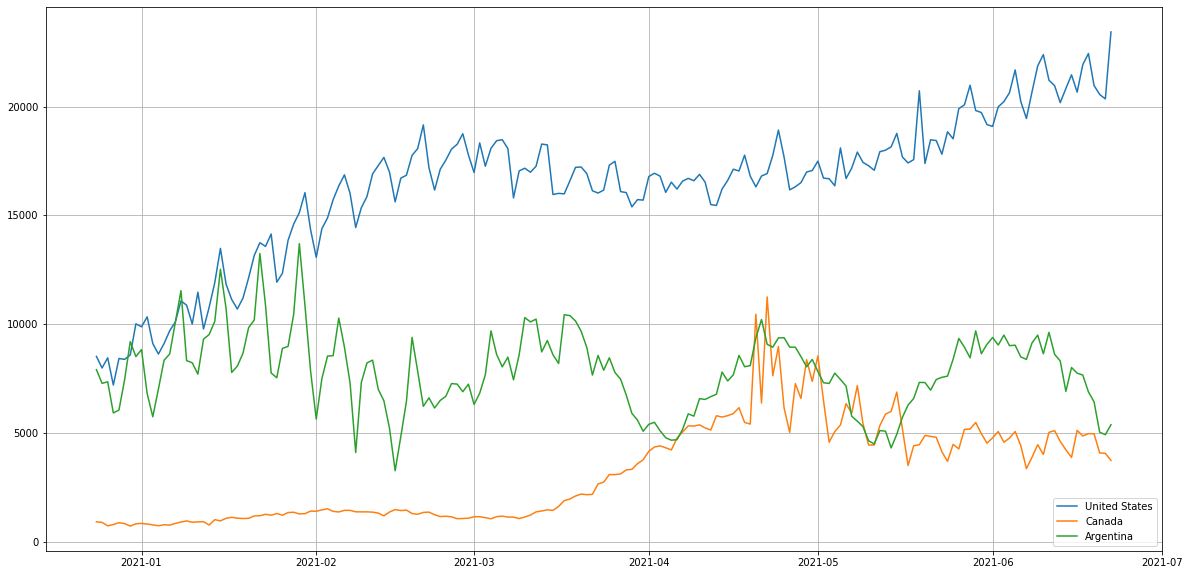

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
pf = pd.read_csv('predictions/val_6_month_future_zero.csv')
pf = pf[['CountryName','Date','PredictedDailyNewCases']]
pf = pf.groupby(['CountryName','Date']).mean()
pf = pf.reset_index()

tf = pf[pf['CountryName']=='United States']
xdates = list(tf['Date'])
xdates = [datetime.datetime.strptime(date,'%Y-%m-%d') for date in xdates]
usa = list(tf['PredictedDailyNewCases'])

tf = pf[pf['CountryName']=='Canada']
can = list(tf['PredictedDailyNewCases'])

tf = pf[pf['CountryName']=='Argentina']
arg = list(tf['PredictedDailyNewCases'])

fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)
plt.plot(xdates, usa,label='United States')
plt.plot(xdates, can,label='Canada')
plt.plot(xdates, arg,label='Argentina')
plt.legend(loc=4)
plt.grid()
plt.show()

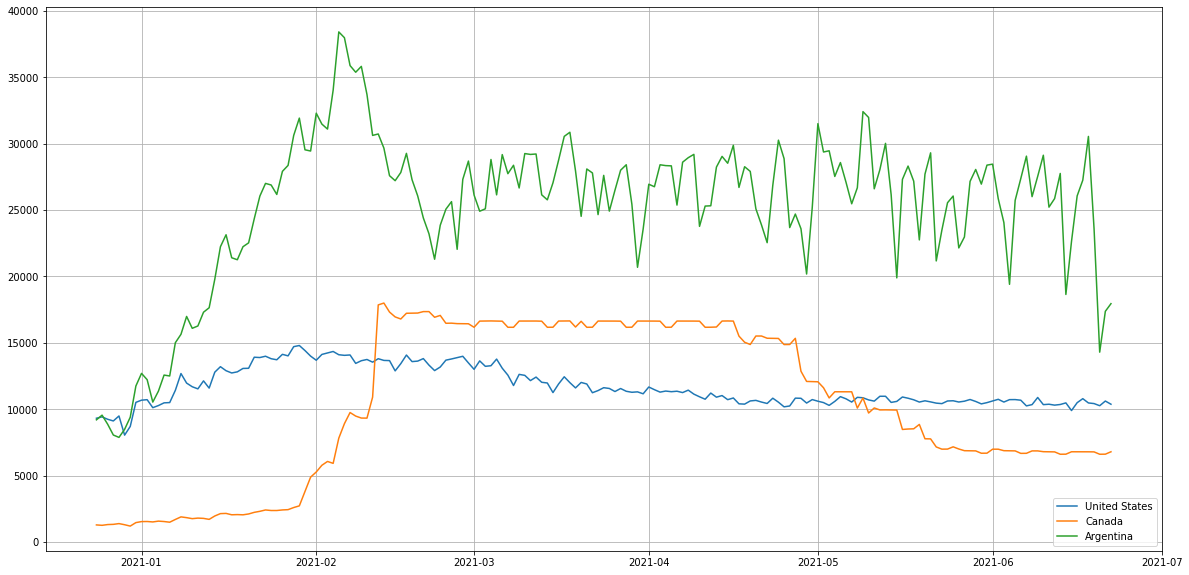

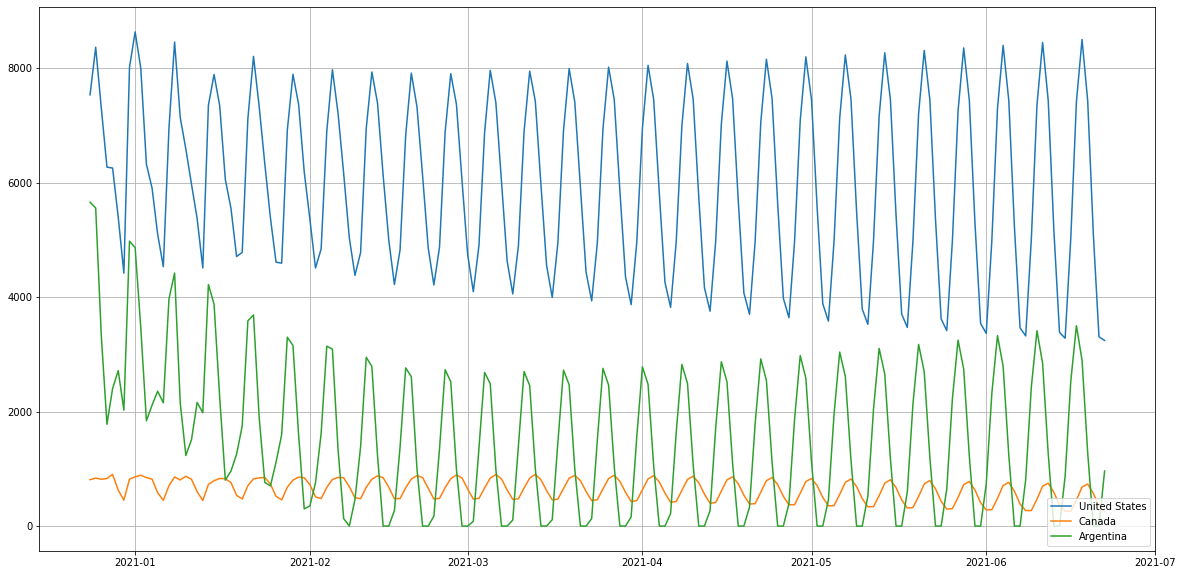